## Initial Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.datasets.kinetics import Kinetics400

from IPython.display import Video
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Path.ls = lambda x: [o.name for o in x.iterdir()]

### Video Transformations from [`pytorch/vision/references/video_classification/transforms.py` ](https://github.com/pytorch/vision/blob/master/references/video_classification/transforms.py)

In [2]:
import torch
import random

# NOTE: for those functions, which generally expect mini-batches, we keep them
# as non-minibatch so that they are applied as if they were 4d (thus image).
# this way, we only apply the transformation in the spatial domain
def resize(vid, size, interpolation='bilinear'):
    # NOTE: using bilinear interpolation because we don't work on minibatches
    # at this level
    scale = None
    if isinstance(size, int):
        scale = float(size) / min(vid.shape[-2:])
        size = None
    return torch.nn.functional.interpolate(
        vid, size=size, scale_factor=scale, mode=interpolation, align_corners=False)


def to_normalized_float_tensor(vid):
    return vid.permute(3, 0, 1, 2).to(torch.float32) / 255


def normalize(vid, mean, std):
    shape = (-1,) + (1,) * (vid.dim() - 1)
    mean = torch.as_tensor(mean).reshape(shape)
    std = torch.as_tensor(std).reshape(shape)
    return (vid - mean) / std


# Class interface


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, vid):
        return resize(vid, self.size)


class ToFloatTensorInZeroOne(object):
    def __call__(self, vid):
        return to_normalized_float_tensor(vid)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, vid):
        return normalize(vid, self.mean, self.std)

## Constructing the Dataset 

Using `torchvision.datasets.kinetics.Kinetics400`

In [3]:
base_dir = Path('/home/rahul/github_projects/video-classification/')
data_dir = base_dir/'data'

In [4]:
!tree {data_dir/'train'}

/home/rahul/github_projects/video-classification/data/train
├── class1
│   ├── c1-sample1.mp4
│   └── c1-sample2.mp4
└── class2
    ├── c2-sample1.mp4
    └── c2-sample2.mp4

2 directories, 4 files


In [5]:
data = Kinetics400(data_dir/'train',
                   step_between_clips = 1,
                   extensions         = ('mp4',),
                   frames_per_clip    = 32,
                   frame_rate = None)

  0%|          | 0/1 [00:00<?, ?it/s]/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +
100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


In [6]:
data[0][0].shape

/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


torch.Size([32, 900, 1600, 3])

## Seeing the Data to Understand What Exactly is in the Training Data

### Helper Functions

In [7]:
def get_metadata(data):
    """
    Takes in a `Kinetics400` dataset, computes the no. of frames in each data point
    and returns in a DataFrame
    
    Parameters
    ----------
    data : torchvision.datasets.kinetics.Kinetics400
        A `Kinetics400` like video dataset (Kinetics400 can be used as a cookie
        cutter for any standard video dataset)
        
    Returns
    -------
    metadata : pd.DataFrame
        A dataframe listing the names, no. of frames, FPS, and no. of subclips create for each video 
        in the dataset.
            * The `# Subclips` column tells us which video's sample will be returned when we index
              into the dataset like so: `data[0]`
        
    """
    fnames     = [f.rsplit('/')[-1] for f in data.metadata['video_paths']]
    num_frames = [len(pts) for pts in data.metadata['video_pts']]
    fps        = [i for i in data.metadata['video_fps']]
    subclips   = [len(x) for x in data.video_clips.clips]

    metadata = pd.DataFrame(list(zip(fnames, num_frames, fps, subclips)),
                            columns = ['Filename', '# Frames', 'FPS', '# Subclips'])
    print(f'Length of the dataset --> {len(data)}')
    return metadata

In [8]:
def subplot_img(sub_plt, x, i):
    """
    Plot one frame of a 4D video tensor.
    Removes axes and prints Frame # for aesthetic peace of mind
    
    Parameters
    ----------
    
    sub_plt : matplotlib.figure.Figure
        One subplot of `plt.subplots`
    
    x : 4D torch.Tensor or np.array
        Must be of shape (T, H, W, C) (T = num frames)
        
    i : int
        Frame no. that is to be plotted
        
    """
    sub_plt.imshow(x[i])
    sub_plt.set_title(f'Frame #{i+1}')
    sub_plt.axis('off')

In [9]:
def plot_adjacent(x, figsize=(8,5), i1=0, i2=31):
    """
    Plot 2 frames of a video tensor side by side
    
    Parameters
    ----------
    
    x : 4D torch.Tensor or np.array
        Must be of shape (T, H, W, C) (T = num frames)
    
    i1, i2 : int
        Indices of the frames to be plotted
    """
    f, plots = plt.subplots(1, 2, figsize=figsize)
    plots[0] = subplot_img(plots[0], x, i1)
    plots[1] = subplot_img(plots[1], x, i2)

    f.tight_layout()

### Seeing the Training Data

<br>
When the dataset of class `Kinetics400` is constructed with `frames_per_clip = 32`, it doesn't take into consideration any data points which have less than 32 clips. <br>

As seen in the DataFrame above, `c2-sample1` and `c2-sample2` had less than 32 frames, and `[len(x) for x in data.video_clips.clips]` reveals that 0 samples were taken from both these clips. 

For `c1-sample1`, which has exactly 32 clips, one clip gets created, whereas for `c1-sample2`, 16 clips get created, leading to a dataset of `len = 17`. The dataset has 1 sample from `c1-sample1` and 16 samples from `c1-sample2`.

<br>

In [10]:
get_metadata(data)

Length of the dataset --> 17


,Filename,# Frames,FPS,# Subclips
0,c1-sample1.mp4,32,25.0,1
1,c1-sample2.mp4,47,25.0,16
2,c2-sample1.mp4,17,25.0,0
3,c2-sample2.mp4,13,25.0,0


---
<h3> Below are the actual videos

In [11]:
Video('../data/train/class1/c1-sample1.mp4', width=400)

In [12]:
Video('../data/train/class1/c1-sample2.mp4', width=400)

In [13]:
Video('../data/train/class2/c2-sample1.mp4', width=400)

In [14]:
Video('../data/train/class2/c2-sample2.mp4', width=400)

<br>

To fully understand what's happening, look at the first and last frames of selected data samples (indices 0, 1, 2 and 16) below.

<br>

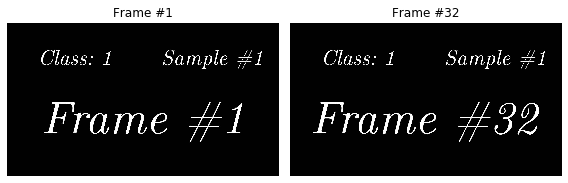

In [15]:
plot_adjacent(data[0][0])

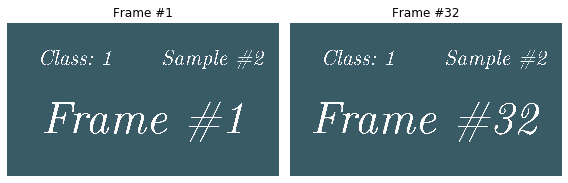

In [16]:
plot_adjacent(data[1][0])

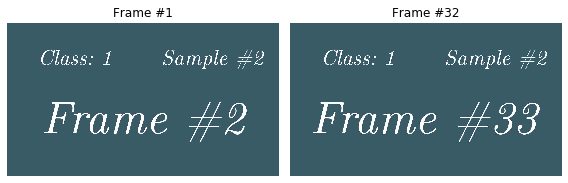

In [17]:
plot_adjacent(data[2][0])

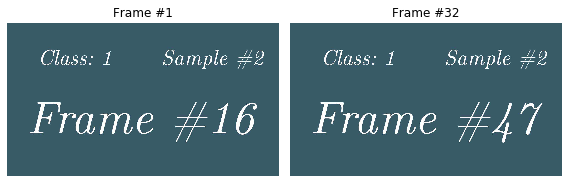

In [18]:
plot_adjacent(data[16][0])

<br>

---

## Data Augmentations

In [19]:
import os
import numpy as np
from skimage.color import label2rgb

import albumentations as A
import random

### Read Video as `Torch Tensor`

This isn't nearly as efficient as `torchvision`'s video reader but is useful to quickly read in a video as a `torch.Tensor` for experiments.

In [20]:
file = '../data/train/class1/c1-sample1.mp4'

In [21]:
def read_video_tensor(filename, probe_i=1):
    """
    Read a file as a 4D numpy tensor with shape (T,H,W,C) (T=num_frames)
    
    Parameters
    ----------
    filename : str
        Path to the video file
        
    probe_i : int
        Index of `ffmpeg.probe(file)['streams']` to extract the video's
        height and width. Usually works as `1` but if the file has no
        audio, you might need to use `0`.
        
    """
    import ffmpeg

    out, _ = (
        ffmpeg
        .input(file)
        .output('pipe:', format='rawvideo', pix_fmt='rgb24')
        .run(capture_stdout=True)
    )

    meta = ffmpeg.probe(file)['streams'][probe_i]
    height, width = meta['height'], meta['width']
    #height, width = 900, 1600

    vid = (
        np
        .frombuffer(out, np.uint8)
        .reshape([-1, height, width, 3])
    )

    return torch.from_numpy(vid)

In [22]:
vid = read_video_tensor(file, probe_i=0)
vid.shape

torch.Size([32, 900, 1600, 3])

### Albumentations on a Single Frame

<br>

`x` is one data sample i.e. a `tensor` of 32 frames/images. To apply albumentations, we'll first apply it on one single frame, then loop and apply over all the frames. As seen below, _not all_ `albumentations` can be applied to `torch.Tensor`s, so they first need to be converted to `np.array`. However, this is a good thing because the `albumentations` always work faster on `np.array` vs. `torch.Tensor`

In [23]:
x = data[3][0]
x.shape

/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


torch.Size([32, 900, 1600, 3])

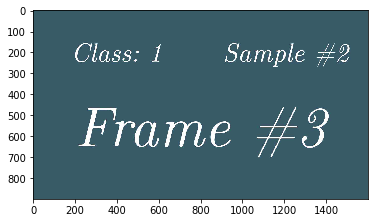

In [24]:
plt.imshow(x[0])

In [25]:
def show(aug, img):
    img = aug(image = img)['image']
    plt.figure(figsize=(6,6))
    plt.imshow(img)

CPU times: user 300 ms, sys: 23 ms, total: 323 ms
Wall time: 40.4 ms


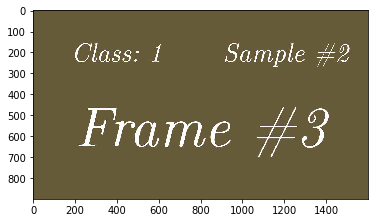

In [26]:
%%time

random.seed(42)
show(A.ChannelShuffle(p=1), np.asarray(x[0]))

In [27]:
for i in x: print(i.shape)

torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])
torch.Size([900, 1600, 3])


CPU times: user 682 ms, sys: 59.2 ms, total: 742 ms
Wall time: 81.4 ms


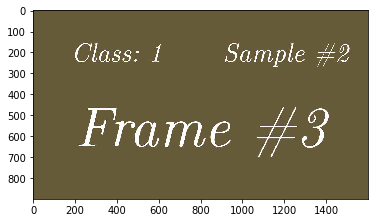

In [28]:
%%time

random.seed(42)
show(A.ChannelShuffle(p=1), x[0])

CPU times: user 233 ms, sys: 15.5 ms, total: 249 ms
Wall time: 31 ms


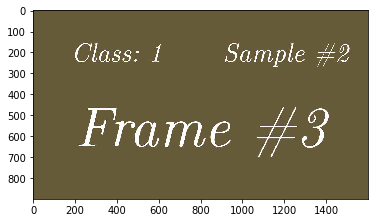

In [29]:
%%time

random.seed(42)
show(A.ChannelShuffle(p=1), np.asarray(x[0]))

In [30]:
%%time

random.seed(42)
show(A.ToGray(p=1), x[0])

TypeError: Expected Ptr<cv::UMat> for argument '%s'

CPU times: user 253 ms, sys: 17.5 ms, total: 271 ms
Wall time: 36.1 ms


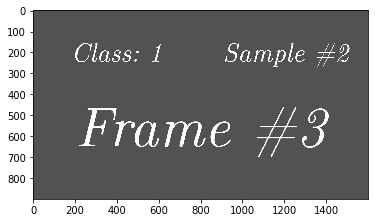

In [31]:
%%time

random.seed(42)
show(A.ToGray(p=1), np.asarray(x[0]))

### Albumentations on a Video i.e. List of Frames

<br>

Here, I define a function `aug_video` which applies a list of `albumentations` to a video. It ensures that the exact same transformation is applied to each frame of the video. This is a must because, for instance, you wouldn't want one frame of the video to be horizontally flipped while the next not. This is done using a constant `random.seed()` value.

In [32]:
file = '../data/tennis.mp4'

In [33]:
vid = read_video_tensor(file)
vid.shape

torch.Size([42, 1080, 1920, 3])

In [34]:
import ffmpeg

out, _ = (
    ffmpeg
    .input(file)
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)

meta = ffmpeg.probe(file)['streams'][1]
height, width = meta['height'], meta['width']

vid = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
)

In [35]:
vid.shape

(42, 1080, 1920, 3)

In [36]:
tfms = A.Compose([
    A.HorizontalFlip(p=0.0),
    #A.ToGray(p=1),
    #A.CLAHE(p=1),
    A.Cutout(p=1),
    A.RandomRain(p=1),
    #A.ChannelDropout(p=1),
    #A.ChannelShuffle(p=1),
    #A.InvertImg(p=1)
])

In [37]:
def aug_video(vid, tfms):
    seed = random.randint(0,99999)
    aug_vid = []
    for x in vid:
        random.seed(seed)
        aug_vid.append((tfms(image = np.asarray(x)))['image'])
    return torch.from_numpy(np.stack(aug_vid))

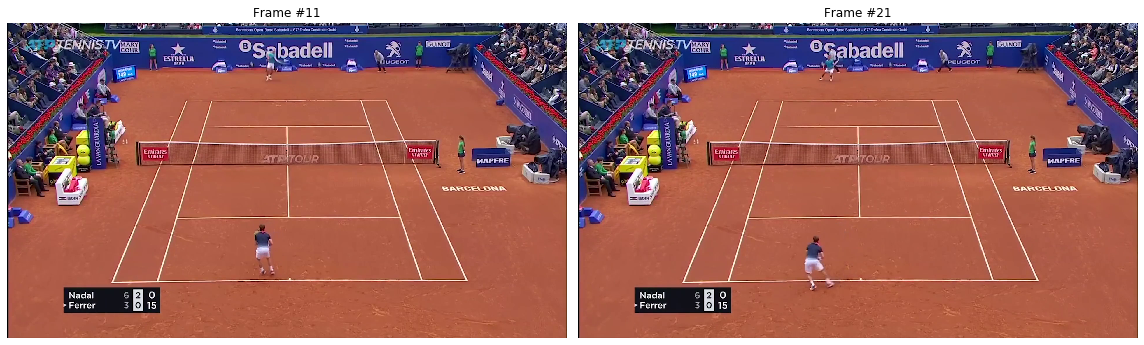

In [38]:
plot_adjacent(vid, figsize=(16, 9), i1=10, i2=20)

torch.Size([42, 1080, 1920, 3])

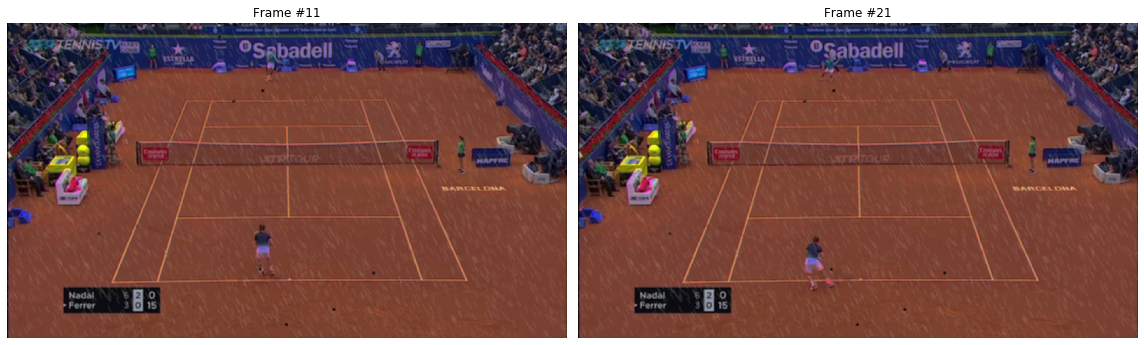

In [39]:
vidaug = (aug_video(vid, tfms))
vidaug.shape
plot_adjacent(vidaug, figsize=(16, 9), i1=10, i2=20)

In [40]:
vid.shape

(42, 1080, 1920, 3)

### Testing to see if the `ToFloatTensorInZeroOne` and `Normalize` from the torchvision Video Transforms can be incorporated in the same `Compose` list as `albumentations`


In [41]:
tmp = torch.from_numpy(vid)
tmp.shape

torch.Size([42, 1080, 1920, 3])

In [42]:
to_normalized_float_tensor(tmp).shape

torch.Size([3, 42, 1080, 1920])

In [43]:
tmp.shape[-2:]

torch.Size([1920, 3])

In [44]:
def normalize(vid, mean, std):
    shape = (-1,) + (1,) * (vid.dim() - 1)
    mean = torch.as_tensor(mean).reshape(shape)
    std = torch.as_tensor(std).reshape(shape)
    return (vid - mean) / std

mean = [0.43216, 0.394666, 0.37645]
std  = [0.22803, 0.22145, 0.216989]

In [45]:
shape = (-1,) + (1,) * (tmp.dim() - 1)
shape

(-1, 1, 1, 1)

In [46]:
torch.as_tensor(mean).shape

torch.Size([3])

In [47]:
# in the official code
(torch.as_tensor(mean).reshape(shape)).shape

torch.Size([3, 1, 1, 1])

In [48]:
# recreating to see if same result can be optained with `C` axis at end instead of beginning
torch.as_tensor(mean)[..., None, None, None].shape

torch.Size([3, 1, 1, 1])

In [49]:
torch.as_tensor(mean)[None, None, None].shape

torch.Size([1, 1, 1, 3])

In [50]:
raw_shape = (tmp/255. - torch.as_tensor(mean)[None, None, None])
raw_shape.shape

torch.Size([42, 1080, 1920, 3])

In [51]:
test_target = to_normalized_float_tensor(tmp) - torch.as_tensor(mean).reshape(shape)
test_target.shape

torch.Size([3, 42, 1080, 1920])

In [52]:
to_normalized_float_tensor(raw_shape).shape == test_target.shape

True

In [53]:
to_normalized_float_tensor(raw_shape) == test_target

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

---

### Combining Torchvision Normalising and Albumentations

<br>

**They can't** be combined in one `Compose`(or it's too painful to make it happen). <br>
Instead, in the following chunk of `__getitem__` function of `Kinetics400`...

```python
if self.transform is not None:
    video = self.transform(video) 
```

... we can pass in only the normalisation functions, and then add another line to call the `albumentations` transformations, like so:

```python
if self.transform is not None:
    video = self.transform(video) # Torchvision `ToFloatTensorInZeroOne` and `Normalize`. Returns shape (C,T,H,W)
    video = self.tfms_albumentations(video) # Albumentations Transforms
```

In order to do so, we'll need to tweak the `aug_video` function defined in the above section to `permute` to the appropriate shape `(T,H,W,C)`, and after the `albumentations` transforms are done, `permute` back to shape `(C,T,H,W)`

In [54]:
tfms_torch = torchvision.transforms.Compose([
    ToFloatTensorInZeroOne(),
    Normalize(mean=[0.43216, 0.394666, 0.37645],
              std=[0.22803, 0.22145, 0.216989])
])

In [55]:
vidaug.shape

torch.Size([42, 1080, 1920, 3])

In [56]:
tfms_torch(vidaug).shape

torch.Size([3, 42, 1080, 1920])

In [57]:
tfms_torch(vidaug).permute(1,2,3,0).shape

torch.Size([42, 1080, 1920, 3])

Redefine `aug_video` for combining both kinds of transformations -- accomodate changing sizes

In [58]:
def aug_torch_video(vid, tfms):
    seed = random.randint(0,99999)
    vid = vid.permute(1,2,3,0) # added line of code
    aug_vid = []
    for x in vid:
        random.seed(seed)
        aug_vid.append((tfms(image = np.asarray(x)))['image'])
    return torch.from_numpy(np.stack(aug_vid)).permute(3,0,1,2)

In [59]:
def combine_tfms(vid, tfms_torch, tfms_albu):
    if not isinstance(vid, torch.Tensor): vid = torch.from_numpy(vid)
    return aug_torch_video(tfms_torch(vid), tfms_albu)

In [126]:
tfms_albu = A.Compose([
    A.HorizontalFlip(p=1),
    A.ChannelShuffle(p=1)
])

In [127]:
vid.shape

(42, 1080, 1920, 3)

In [128]:
combined = combine_tfms(vid, tfms_torch, tfms_albu)
combined.shape

torch.Size([3, 42, 1080, 1920])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


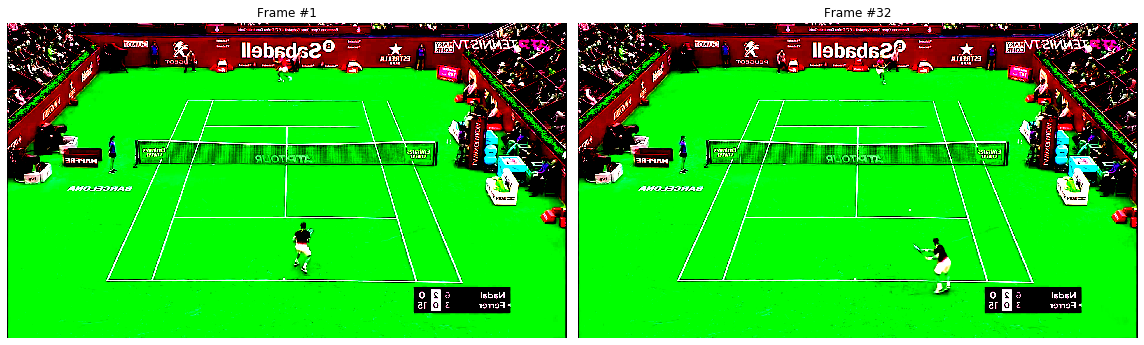

In [133]:
plot_adjacent(combined.permute(1,2,3,0), figsize=(16,10))

## Defining a New Video Dataset Constructor (Based on Kinetics400)

<br>

<h3> Added Features: </h3>

* Accomodates `albumentations` data augmentations
* Adds another `info` function which gives useful info about the dataset i.e. the `get_metadata()` function defined earlier in the notebook)

In [64]:
from torchvision.datasets.utils import list_dir
from torchvision.datasets.folder import make_dataset
from torchvision.datasets.video_utils import VideoClips
from torchvision.datasets.vision import VisionDataset
import albumentations as A

In [135]:
def apply_tfms_albu(vid, tfms_albu):
    """
    Parameters
    ----------
        vid : torch.Tensor
    """
    seed    = random.randint(0,99999)
    vid     = vid.permute(1,2,3,0) # added line of code
    aug_vid = []
    for x in vid:
        random.seed(seed)
        aug_vid.append((tfms_albu(image = np.asarray(x)))['image'])
    return torch.from_numpy(np.stack(aug_vid)).permute(3,0,1,2)

In [170]:
tfms_torch = torchvision.transforms.Compose([
    ToFloatTensorInZeroOne(),
    Resize((128*3, 227*3)),
    Normalize(mean=[0.43216, 0.394666, 0.37645],
              std=[0.22803, 0.22145, 0.216989])
])

In [311]:
def get_tfms_albu(): return A.Compose([
        A.HorizontalFlip(),
        A.ShiftScaleRotate(rotate_limit=15, p=0.2),
        A.ChannelDropout(p=0.2),
        A.RandomRain(p=0.1),
        A.GridDistortion(p=0.2)
    ], p=0.6)

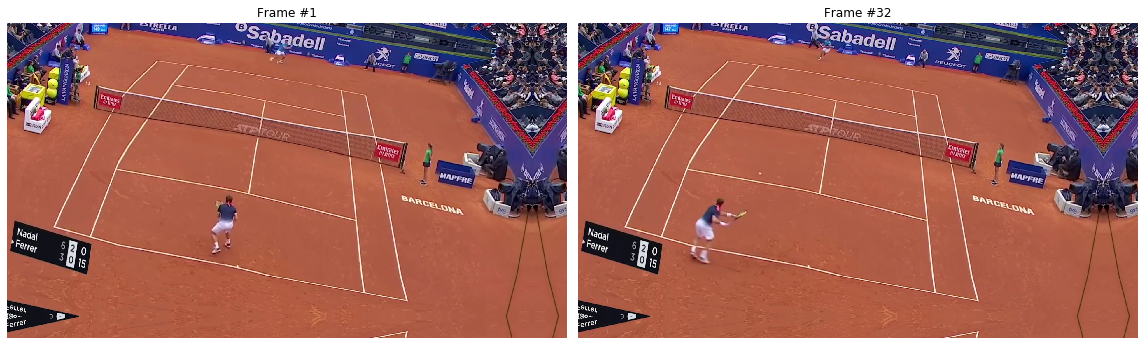

In [262]:
plot_adjacent(aug_video(vid, get_tfms_albu()), figsize=(16,10))

In [263]:
class VideoDataset(VisionDataset):
    """
    This dataset consider every video as a collection of video clips of fixed size, specified
    by ``frames_per_clip``, where the step in frames between each clip is given by
    ``step_between_clips``.

    To give an example, for 2 videos with 10 and 15 frames respectively, if ``frames_per_clip=5``
    and ``step_between_clips=5``, the dataset size will be (2 + 3) = 5, where the first two
    elements will come from video 1, and the next three elements from video 2.
    Note that we drop clips which do not have exactly ``frames_per_clip`` elements, so not all
    frames in a video might be present.

    Internally, it uses a VideoClips object to handle clip creation.

    Parameters
    ----------
        root : string
            Root directory of the dataset.
            
        frames_per_clip : int
            number of frames in a clip
            
        step_between_clips : int
            number of frames between each clip
            
        transform (callable, optional): A function/transform that  takes in a TxHxWxC video
            and returns a transformed version.

    Returns
    -------
        video : Tensor[T, H, W, C]
            Tensor of shape (T, H, W, C) where `T = num_frames`
            
        audio : Tensor[K, L]: 
            the audio frames, where `K` is the number of channels
            and `L` is the number of points
            
        label : int
            class of the video clip
    """

    def __init__(self, root, frames_per_clip, step_between_clips=1, frame_rate=None,
                 extensions=('mp4',), tfms_torch=None, tfms_albu=None, _precomputed_metadata=None,
                 num_workers=1, _video_width=0, _video_height=0,
                 _video_min_dimension=0, _audio_samples=0):
        super(VideoDataset, self).__init__(root)

        classes      = list(sorted(list_dir(root)))
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        self.samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file=None)
        self.classes = classes
        video_list   = [x[0] for x in self.samples]
        self.video_clips = VideoClips(
            video_list,
            frames_per_clip,
            step_between_clips,
            frame_rate,
            _precomputed_metadata,
            num_workers=num_workers,
            _video_width=_video_width,
            _video_height=_video_height,
            _video_min_dimension=_video_min_dimension,
            _audio_samples=_audio_samples,
        )
        self.tfms_torch = tfms_torch
        self.tfms_albu  = tfms_albu

    @property
    def metadata(self):
        return self.video_clips.metadata

    def get_info(self):
        fnames     = [f.rsplit('/')[-1] for f   in self.video_clips.metadata['video_paths']]
        classes    = [f.rsplit('/')[-2] for f   in data.video_clips.metadata['video_paths']]
        num_frames = [len(pts)          for pts in self.video_clips.metadata['video_pts']]
        fps        = [i                 for i   in self.video_clips.metadata['video_fps']]
        subclips   = [len(x)            for x   in self.video_clips.clips]
        

        info = pd.DataFrame(data    = list(zip(fnames, classes, num_frames, fps, subclips)),
                            columns = ['Filename', 'Class', '# Frames', 'FPS', '# Subclips'])
        return info
    
    def __len__(self):
        return self.video_clips.num_clips()

    def __getitem__(self, idx):
        video, audio, info, video_idx = self.video_clips.get_clip(idx)
        label = self.samples[video_idx][1]

        # As of now, this assumes that tfms_torch and tfms_albu have been passed. Need to account for if not.
        video = apply_tfms_albu(self.tfms_torch(video), self.tfms_albu)

        return video, audio, label

In [274]:
data = VideoDataset('/home/rahul/Desktop/tennis-dataset-1-minimal/train/',
                    step_between_clips = 3,
                    frames_per_clip    = 16,
                    frame_rate = None,
                    tfms_torch = tfms_torch,
                    tfms_albu  = get_tfms_albu())

  0%|          | 0/2 [00:00<?, ?it/s]/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +
100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


In [275]:
data.get_info()

,Filename,Class,# Frames,FPS,# Subclips
0,point#1_shot#11_David_Ferrer_-_Best-Ever_Roadr...,backhand,42,25.0,9
1,point#1_shot#13_David_Ferrer_-_Best-Ever_Roadr...,backhand,43,25.0,10
2,point#1_shot#14_David_Ferrer_-_Best-Ever_Roadr...,backhand,42,25.0,9
3,point#1_shot#4_Best_ATP_Tennis_Matches_in_2018...,backhand,50,25.0,12
4,point#1_shot#5_Best_ATP_Tennis_Matches_in_2018...,backhand,36,25.0,7
5,point#1_shot#6_Best_ATP_Tennis_Matches_in_2018...,backhand,32,25.0,6
6,point#1_shot#6_David_Ferrer_-_Best-Ever_Roadru...,backhand,39,25.0,8
7,point#1_shot#9_Best_ATP_Tennis_Matches_in_2018...,backhand,24,25.0,3
8,point#1_shot#9_David_Ferrer_-_Best-Ever_Roadru...,backhand,44,25.0,10
9,point#3_shot#2_David_Ferrer_-_Best-Ever_Roadru...,backhand,39,25.0,8


In [276]:
data[43][0].shape

/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


torch.Size([3, 16, 384, 681])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


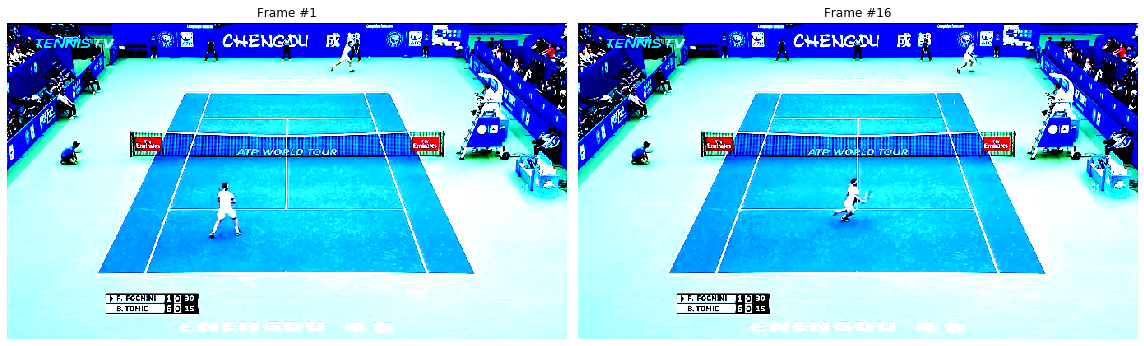

In [283]:
plot_adjacent(data[43][0].permute(1,2,3,0), figsize=(16,10), i2=15)

## Understanding Samplers -- RandomClipSampler

### Setup

In [285]:
from torchvision.datasets.samplers import *

In [286]:
??RandomClipSampler

In [287]:
data

Dataset VideoDataset
    Number of datapoints: 189
    Root location: /home/rahul/Desktop/tennis-dataset-1-minimal/train/

In [288]:
max_clips_per_video = 3
sampler = RandomClipSampler(data.video_clips, max_clips_per_video)

In [289]:
for x in sampler: print(x)

135
145
181
134
79
63
81
69
51
114
11
92
82
58
37
155
41
143
95
2
62
45
168
97
23
1
12
171
105
138
43
20
174
158
0
163
173
48
186
84
61
177
49
71
66
38
184
60
16
78
107
161
27
127
108
144
125
28
56
87


### Understanding `RandomClipSampler`'s   `__iter__`

In [290]:
len(data.video_clips.clips)

# no. of subclips of each video in the dataset
# the `x` below actualls contains the `pts` i.e. 
# timestamps (of ffmpeg's unit) i.e. indexes of frames of the video
[x.shape for x in data.video_clips.clips] 

20

[torch.Size([9, 16]),
 torch.Size([10, 16]),
 torch.Size([9, 16]),
 torch.Size([12, 16]),
 torch.Size([7, 16]),
 torch.Size([6, 16]),
 torch.Size([8, 16]),
 torch.Size([3, 16]),
 torch.Size([10, 16]),
 torch.Size([8, 16]),
 torch.Size([7, 16]),
 torch.Size([15, 16]),
 torch.Size([9, 16]),
 torch.Size([18, 16]),
 torch.Size([10, 16]),
 torch.Size([11, 16]),
 torch.Size([11, 16]),
 torch.Size([10, 16]),
 torch.Size([7, 16]),
 torch.Size([9, 16])]

In [291]:
torch.randperm(16)[:3] + 0

tensor([ 4, 15,  7])

In [295]:
idxs = []
s = 0 # counter for ensuring the idxs returned are for the correct video in the dataset

# select at most max_clips_per_video for each video, randomly
for i,c in enumerate(data.video_clips.clips):
    print(f'\n--------------------- Data sample # {i} ---------------------')
    length = len(c)
    print(f'No. of subclips per video in the dataset    [length]  --> {length}')
    size = min(length, max_clips_per_video)
    print(f'No. of clips that will be sampled per video [size]    --> {size}')
    # `+ s` ensures that the indexes are returned for the correct video
    sampled = torch.randperm(length)[:size] + s
    #print(f's = {s}')
    print(f'Which of the {length} subclips will be returned   [sampled] --> {sampled}')
    s += length
    idxs.append(sampled)


--------------------- Data sample # 0 ---------------------
No. of subclips per video in the dataset    [length]  --> 9
No. of clips that will be sampled per video [size]    --> 3
Which of the 9 subclips will be returned   [sampled] --> tensor([1, 6, 5])

--------------------- Data sample # 1 ---------------------
No. of subclips per video in the dataset    [length]  --> 10
No. of clips that will be sampled per video [size]    --> 3
Which of the 10 subclips will be returned   [sampled] --> tensor([14, 16, 10])

--------------------- Data sample # 2 ---------------------
No. of subclips per video in the dataset    [length]  --> 9
No. of clips that will be sampled per video [size]    --> 3
Which of the 9 subclips will be returned   [sampled] --> tensor([22, 20, 25])

--------------------- Data sample # 3 ---------------------
No. of subclips per video in the dataset    [length]  --> 12
No. of clips that will be sampled per video [size]    --> 3
Which of the 12 subclips will be returned 

In [296]:
idxs = torch.cat(idxs)
print(f'List of indexes to pull from the dataset                    -->  {idxs.tolist()}')

perm = torch.randperm(len(idxs))
idxs = idxs[perm].tolist()

print(f'\nThe sampler returns a randomised version of the above list  -->  {idxs}')

List of indexes to pull from the dataset                    -->  [1, 6, 5, 14, 16, 10, 22, 20, 25, 39, 35, 36, 41, 40, 42, 47, 50, 51, 60, 59, 57, 61, 63, 62, 65, 72, 68, 78, 77, 74, 84, 83, 88, 90, 95, 100, 110, 109, 107, 116, 115, 113, 138, 135, 136, 147, 151, 141, 158, 154, 160, 165, 170, 164, 174, 175, 178, 188, 180, 186]

The sampler returns a randomised version of the above list  -->  [41, 1, 62, 90, 88, 10, 164, 40, 57, 83, 113, 72, 22, 180, 42, 188, 50, 60, 47, 115, 35, 141, 136, 5, 154, 170, 158, 16, 147, 175, 95, 100, 135, 51, 78, 186, 39, 61, 110, 174, 6, 109, 160, 165, 138, 84, 20, 107, 178, 14, 65, 25, 151, 116, 59, 68, 74, 63, 77, 36]


## Playing around with Fastai

It seems like it will take a lot of work to integrate video classification with `fastai`. <br>
It would be faster to build `torchvision`'s script.

**Successes**:
* Created `DataBunch`
* Created `Learner`
* Can use `Learner.to_fp16()`

**Failures**:
* `DataBunch.show_batch()` Not adapted for video.
* `Learner.lr_find()` I tried commenting out a line in `fastai/fastai/train.py` to make this run but it hung the system and crashed the kernel after I did. Probably because this line called the callback for `on_epoch_begin`
* `Learner.freeze()` fails because there's only one layer group. But when you look at `Learner.model`, the model is divided into different modules.

In [297]:
%reload_ext autoreload
%autoreload 2

In [298]:
from fastai.vision import *

In [299]:
DataBunch??

In [300]:
Learner??

In [301]:
??cnn_learner

In [302]:
??DataBunch

In [303]:
??Collection

In [304]:
dt = DataBunch(train_dl=torch.utils.data.DataLoader(data, sampler = sampler), valid_dl=torch.utils.data.DataLoader(data, sampler = sampler))
dt

DataBunch;

Train: Dataset VideoDataset
    Number of datapoints: 189
    Root location: /home/rahul/Desktop/tennis-dataset-1-minimal/train/;

Valid: Dataset VideoDataset
    Number of datapoints: 189
    Root location: /home/rahul/Desktop/tennis-dataset-1-minimal/train/;

Test: None

In [81]:
dt.show_batch()

/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


ValueError: too many values to unpack (expected 2)

In [305]:
torch.hub.list("moabitcoin/ig65m-pytorch")

Using cache found in /home/rahul/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


['r2plus1d_34_32_ig65m',
 'r2plus1d_34_32_kinetics',
 'r2plus1d_34_8_ig65m',
 'r2plus1d_34_8_kinetics']

In [306]:
model = torch.hub.load("moabitcoin/ig65m-pytorch", "r2plus1d_34_32_ig65m", num_classes=359, pretrained=True)
model.fc.out_features = len(data.classes)

Using cache found in /home/rahul/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


In [307]:
learn = Learner(data=dt, model=model, loss_func=nn.CrossEntropyLoss())

modify `fastai/fastai/basic_train.py` and comment out this line to prevent callback (it isn't designed to work with video)
```python
    100                 xb, yb = cb_handler.on_batch_begin(xb, yb)
```

In [89]:
learn.lr_find??

In [308]:
learn = learn.to_fp16()

In [95]:
dt.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f5b7e433450>, device=device(type='cuda'), tfms=[<function batch_to_half at 0x7f5b97ab6f80>], collate_fn=<function data_collate at 0x7f5b97ab64d0>)

In [97]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

In [101]:
learn.layer_groups

[Sequential(
   (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
   (1): BatchNorm3d(45, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
   (4): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
   (5): ReLU(inplace=True)
   (6): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
   (7): BatchNorm3d(144, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
   (8): ReLU(inplace=True)
   (9): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
   (10): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
   (11): ReLU(inplace=True)
   (12): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
   (13): BatchNorm3d(144, eps=0.001, momentum=

In [309]:
learn.model.state_dict

<bound method Module.state_dict of VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=0.001, momentum=0.9, a

In [98]:
learn.freeze()

AssertionError: 

In [111]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time


/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


RuntimeError: Given groups=1, weight of size 45 3 1 7 7, expected input[1, 32, 900, 1600, 3] to have 3 channels, but got 32 channels instead

In [114]:
Learner??

In [310]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time


/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


TypeError: list indices must be integers or slices, not tuple

## .